# Metrics Analysis Notebook
Select a `calls_metrics.jsonl` file, then run the remaining cells.

## File Selection


### Choose manually
run the first cell
use the dropdown
then run the second cell
if you ever want to change it then you must change the dropdown and run the second cell again

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import ipywidgets as widgets
from IPython.display import display
from pathlib import Path

# Set the directory containing your metrics files
metrics_dir = Path.cwd() 
jsonl_files = list(metrics_dir.glob("*.jsonl"))

if not jsonl_files:
    print("No .jsonl files found in this directory.")
else:
    file_dropdown = widgets.Dropdown(
        options=[(f.name, f) for f in jsonl_files],
        description='Select file:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%')
    )
    display(file_dropdown)

    # Example: get the selected file path
    def on_file_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            print(f"Selected file: {change['new']}")

    file_dropdown.observe(on_file_change)
    print(file_dropdown.value)

Dropdown(description='Select file:', layout=Layout(width='50%'), options=(('clinical_trial_calls_20250504_1844…

c:\Users\wasab\Documents\code\python\Clinical-Trial-Prompts\output\metrics\clinical_trial_calls_20250504_184415 copy.jsonl


if you change something from the above dropdown make sure to also run the line below to set it in stone

In [ ]:
metrics_path = file_dropdown.value
print(f"Selected file: {metrics_path}")

Selected file: c:\Users\wasab\Documents\code\python\Clinical-Trial-Prompts\output\metrics\clinical_trial_calls_20250504_184415 copy.jsonl


### latest time stamped file
if instead you just want the latest run then run this cell below

In [2]:
from pathlib import Path
import re

# Set the directory containing your metrics files
metrics_dir = Path.cwd()  # or Path to your metrics directory

# Regex to match the filename pattern and extract the timestamp
pattern = re.compile(r"clinical_trial_calls_(\d{8}_\d{6})\.jsonl")

# Find all matching files and extract their timestamps
files_with_timestamps = []
for f in metrics_dir.glob("clinical_trial_calls_*.jsonl"):
    if m := pattern.match(f.name):
        files_with_timestamps.append((m[1], f))

if not files_with_timestamps:
    print("No matching .jsonl files found.")
else:
    # Sort by timestamp (descending) and pick the latest
    latest_file = max(files_with_timestamps, key=lambda x: x[0])[1]
    print(f"Latest metrics file: {latest_file}")
    metrics_path = latest_file

Latest metrics file: c:\Users\wasab\Documents\code\python\Clinical-Trial-Prompts\output\metrics\clinical_trial_calls_20250504_203410.jsonl


### verify you have the right file

In [53]:
print(metrics_path)

c:\Users\wasab\Documents\code\python\Clinical-Trial-Prompts\output\metrics\clinical_trial_calls_20250504_203410.jsonl


## Actual analysis

### setup

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

assert metrics_path.exists(), f'File not found: {metrics_path}'
df = pd.read_json(metrics_path, lines=True, convert_dates=['ts'])
df['ts'] = pd.to_datetime(df['ts'], unit='s')
df.set_index('ts', inplace=True, drop=False)
df['elapsed_time'] = (df.index - df.index[0]).total_seconds()
df['pred_err'] = df['pred_completion'] - df['completion_tokens']
df = df.set_index('elapsed_time', drop=False) 
print(f'Loaded {len(df):,} call records from', metrics_path)
# Display all columns in the DataFrame
print(df.columns)
print(df.head())

Loaded 13,328 call records from c:\Users\wasab\Documents\code\python\Clinical-Trial-Prompts\output\metrics\clinical_trial_calls_20250504_203410.jsonl
Index(['ts', 'retry', 'prompt_tokens', 'schema_tokens', 'pred_completion',
       'completion_tokens', 'prompt_cached', 'total_tokens', 'lat_ms',
       'sem_capacity', 'error', '=', 'elapsed_time', 'pred_err'],
      dtype='object')
                                        ts  retry  prompt_tokens  \
elapsed_time                                                       
0.000000     2025-05-05 00:34:22.302074909    0.0             96   
0.007897     2025-05-05 00:34:22.309972286    0.0            101   
0.029372     2025-05-05 00:34:22.331447363    0.0             94   
0.057103     2025-05-05 00:34:22.359177828    0.0             94   
0.066936     2025-05-05 00:34:22.369010448    0.0             91   

              schema_tokens  pred_completion  completion_tokens  \
elapsed_time                                                      
0.000

### Token Charts

In [73]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

token_cols = {
    "Prompt Tokens": "prompt_tokens",
    "Cached Prompt": "prompt_cached",
    "Predicted Completion": "pred_completion",
    "Actual Completion": "completion_tokens",
    "Prediction Error": "pred_err",
}

@interact(
    prompt     = widgets.Checkbox(True,  description="Prompt"),
    cached     = widgets.Checkbox(True,  description="Cached"),
    pred       = widgets.Checkbox(True,  description="Predicted"),
    actual     = widgets.Checkbox(True,  description="Actual"),
    pred_err   = widgets.Checkbox(False, description="Prediction Error"),
    window     = widgets.IntSlider(100, min=1, max=1000, step=1, description="Window"),
    log_scale  = widgets.Checkbox(False, description="Logarithmic Y-Axis"),
)
def update_plot(prompt, cached, pred, actual, pred_err, window, log_scale):
    plt.figure(figsize=(12,6))

    x = df['elapsed_time']                        # seconds since start

    if prompt:
        y = df[token_cols["Prompt Tokens"]].rolling(window).mean()
        plt.plot(x, y, label="Prompt Tokens")
    if cached:
        y = df[token_cols["Cached Prompt"]].rolling(window).mean()
        plt.plot(x, y, label="Cached Prompt")
    if pred:
        y = df[token_cols["Predicted Completion"]].rolling(window).mean()
        plt.plot(x, y, label="Predicted Completion")
    if actual:
        y = df[token_cols["Actual Completion"]].rolling(window).mean()
        plt.plot(x, y, label="Completion Tokens")
    if pred_err:
        y = df[token_cols["Prediction Error"]].rolling(window).mean()
        plt.plot(x, y, label="Prediction Error")

    plt.title(f"Token metrics per call ({window}-call rolling mean)")
    plt.xlabel("Elapsed Time (seconds)")
    plt.ylabel("Tokens (log scale)" if log_scale else "Tokens")
    plt.yscale('log' if log_scale else 'linear')
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


interactive(children=(Checkbox(value=True, description='Prompt'), Checkbox(value=True, description='Cached'), …

In [72]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

token_cols = {
    "Prompt Tokens": "prompt_tokens",
    "Cached Prompt": "prompt_cached",
    "Predicted Completion": "pred_completion",
    "Actual Completion": "completion_tokens",
    "Prediction Error": "pred_err",
}

@interact(
    prompt     = widgets.Checkbox(True,  description="Prompt"),
    cached     = widgets.Checkbox(True,  description="Cached"),
    pred       = widgets.Checkbox(True,  description="Predicted"),
    actual     = widgets.Checkbox(True,  description="Actual"),
    pred_err   = widgets.Checkbox(False, description="Prediction Error"),
    bins       = widgets.IntSlider(50, min=10, max=200, step=5, description="Bins"),
    log_scale  = widgets.Checkbox(False, description="Logarithmic Y-Axis"),
)
def plot_distribution(prompt, cached, pred, actual, pred_err, bins, log_scale):
    plt.figure(figsize=(12,6))

    if prompt:
        plt.hist(df[token_cols["Prompt Tokens"]], bins=bins, alpha=0.6, label="Prompt Tokens")
    if cached:
        plt.hist(df[token_cols["Cached Prompt"]], bins=bins, alpha=0.6, label="Cached Prompt")
    if pred:
        plt.hist(df[token_cols["Predicted Completion"]], bins=bins, alpha=0.6, label="Predicted Completion")
    if actual:
        plt.hist(df[token_cols["Actual Completion"]], bins=bins, alpha=0.6, label="Completion Tokens")
    if pred_err:
        plt.hist(df[token_cols["Prediction Error"]], bins=bins, alpha=0.6, label="Prediction Error")

    plt.title("Distribution of Token Metrics")
    plt.xlabel("Tokens")
    plt.ylabel("Frequency (Log)" if log_scale else "Frequency")
    plt.yscale("log" if log_scale else "linear")
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


interactive(children=(Checkbox(value=True, description='Prompt'), Checkbox(value=True, description='Cached'), …

### Latency and retry

In [ ]:
@interact(
    window=widgets.IntSlider(value=100, min=1, max=1000, step=1,description="Window"),
    log_scale=widgets.Checkbox(False, description="Logarithmic Y-Axis"),
)
def plot_latency(window, log_scale):
    x = df['elapsed_time']                     # seconds since start
    y = df['lat_ms'].rolling(window).mean()    # rolling mean

    plt.figure(figsize=(12, 6))
    plt.plot(x, y, color='tab:blue', label=f'Latency ({window}-call mean)')
    plt.ylabel('Latency (ms) (log scale)' if log_scale else 'Latency (ms)')
    plt.yscale('log' if log_scale else 'linear')
    plt.xlabel('Elapsed Time (seconds)')
    plt.title('Latency per Call')
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


interactive(children=(IntSlider(value=100, description='Window', max=1000, min=1), Checkbox(value=False, descr…

In [75]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

@interact(
    bins=widgets.IntSlider(value=50, min=10, max=200, step=5, description="Bins"),
    log_scale=widgets.Checkbox(False, description="Logarithmic Y-Axis"),
)
def plot_latency_distribution(bins, log_scale):
    plt.figure(figsize=(12, 6))
    plt.hist(df['lat_ms'], bins=bins, alpha=0.7, color='tab:blue', label='Latency (ms)')

    plt.xlabel("Latency (ms)")
    plt.ylabel("Frequency (Log)" if log_scale else "Frequency")
    plt.yscale("log" if log_scale else "linear")
    plt.title("Latency Distribution per Call")
    plt.grid(True, axis='y', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


interactive(children=(IntSlider(value=50, description='Bins', max=200, min=10, step=5), Checkbox(value=False, …

### RPM and TPM raw values but somewhat deceptive y axis

In [69]:
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
# Ensure datetime index
df['ts'] = pd.to_datetime(df['ts'], unit='s')
df.set_index('ts', inplace=True, drop=False)  # Keeps ts column


df = df.sort_index()
# Rolling 60s sum of total tokens (TPM)
tpm_rolling = df['total_tokens'].rolling('60s').sum()

# Rolling 60s count of rows = RPM
rpm_rolling = df['total_tokens'].rolling('60s').count()


@interact(
    show_tpm=widgets.Checkbox(value=True, description='Show TPM (tokens)'),
    show_rpm=widgets.Checkbox(value=True, description='Show RPM (requests)'),
    highlight_errors=widgets.Checkbox(value=True, description='Highlight Errors'),
    highlight_retries=widgets.Checkbox(value=True, description='Highlight Retries'),
)
def plot_with_highlights(show_tpm, show_rpm, highlight_errors, highlight_retries):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()

    x = (tpm_rolling.index - df.index[0]).total_seconds()

    if show_tpm:
        ax1.plot(x, tpm_rolling, label='TPM (tokens)', color='tab:blue')
        ax1.set_ylabel('Tokens per minute', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

    if show_rpm:
        ax2.plot(x, rpm_rolling, label='RPM (requests)', color='tab:orange')
        ax2.set_ylabel('Requests per minute', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Highlight error events
    if highlight_errors:
        error_locs = df[df['error'].notna()]
        x_errors = (error_locs['ts'] - df['ts'].iloc[0]).dt.total_seconds()
        for xe in x_errors:
            ax1.axvline(x=xe, color='red', alpha=0.5, linestyle='--', linewidth=1)
        # Optionally, add a legend entry
        if not error_locs.empty:
            ax1.plot([], [], color='red', alpha=0.5, linestyle='--', label='Error Event')

    # Highlight retry bursts (where retry > 0)
    if highlight_retries:
        retry_locs = df[df['retry'] > 0]
        x_retries = (retry_locs['ts'] - df['ts'].iloc[0]).dt.total_seconds()
        for xr in x_retries:
            ax1.axvline(x=xr, color='green', alpha=0.5, linestyle=':', linewidth=1)
        if not retry_locs.empty:
            ax1.plot([], [], color='green', alpha=0.5, linestyle=':', label='Retry Event')

    ax1.set_xlabel('Elapsed Time (seconds)')
    ax1.set_title('Rolling 60-Second TPM & RPM with Event Highlights')
    ax1.grid(True)

    # Combine legends from both axes
    lines, labels = [], []
    for ax in [ax1, ax2]:
        l, lab = ax.get_legend_handles_labels()
        lines += l
        labels += lab
    ax1.legend(lines, labels, loc='upper left')

    fig.tight_layout()
    plt.show()
    


interactive(children=(Checkbox(value=True, description='Show TPM (tokens)'), Checkbox(value=True, description=…

### RPM and TPM based on percent of max throughput

In [ ]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# ---- constants ------------------------------------------------------------
TPM_IDEAL = 2_000_000
RPM_IDEAL = 2_000

# pre‑compute once so the widget stays snappy
df_sorted = df.sort_index()
elapsed   = (df_sorted.index - df_sorted.index[0]).total_seconds()

tpm_pct = 100 * tpm_rolling / TPM_IDEAL
rpm_pct = 100 * rpm_rolling / RPM_IDEAL
err_cum = df_sorted['error'].notna().cumsum()
ret_cum = df_sorted['retry'].cumsum()

err_spikes_x = (df_sorted[df_sorted['error'].notna()].index - df_sorted.index[0]).total_seconds()
ret_spikes_x = (df_sorted[df_sorted['retry'] > 0].index    - df_sorted.index[0]).total_seconds()

# ---- interactive plot -----------------------------------------------------
@interact(
    show_tpm      =widgets.Checkbox(True, description='TPM %'),
    show_rpm      =widgets.Checkbox(True, description='RPM %'),
    show_errors   =widgets.Checkbox(True, description='Cumulative Errors'),
    show_retries  =widgets.Checkbox(True, description='Cumulative Retries'),
    spikes_errors =widgets.Checkbox(True, description='Error spikes'),
    spikes_retries=widgets.Checkbox(True, description='Retry spikes'),
    spike_alpha   =widgets.FloatSlider(value = 0.25, min = 0.0, max = 1.0, step=0.05, description='Spike alpha'),
)
def plot_combined(show_tpm, show_rpm,show_errors, show_retries,spikes_errors, spikes_retries, spike_alpha):

    fig, ax_left = plt.subplots(figsize=(12,6))
    ax_right = ax_left.twinx()

    # --- left axis: percent of ideal --------------------------------------
    if show_tpm:
        ax_left.plot(elapsed, tpm_pct, color='tab:blue',label='TPM (% of 2M)', linewidth=1.5)
    if show_rpm:
        ax_left.plot(elapsed, rpm_pct, color='tab:orange',label='RPM (% of 2k)', linewidth=1.5)

    ax_left.set_ylabel('Percent of Ideal (%)')
    ax_left.set_xlabel('Elapsed Time (seconds)')
    ax_left.set_ylim(0, max(tpm_pct.max(), rpm_pct.max())*1.1)
    ax_left.grid(True, axis='y', alpha=0.3)

    # --- right axis: cumulative counts ------------------------------------
    if show_errors:
        ax_right.step(elapsed, err_cum, where='post', color='tab:purple', linewidth=2, label='Cum. Errors')
    if show_retries:
        ax_right.step(elapsed, ret_cum, where='post', color='tab:red', linewidth=2, label='Cum. Retries')

    if spikes_errors:
        ax_right.vlines(err_spikes_x, 0, err_cum.max(),
                        color='tab:purple', alpha=spike_alpha,
                        linewidth=(1+spike_alpha), linestyles=':')
    if spikes_retries:
        ax_right.vlines(ret_spikes_x, 0, ret_cum.max(),
                        color='tab:red', alpha=spike_alpha,
                        linewidth=(1+spike_alpha), linestyles='--')

    ax_right.set_ylabel('Cumulative Count')
    ax_right.set_ylim(0, max(err_cum.max(), ret_cum.max())*1.2)

    # --- legend -----------------------------------------------------------
    lines_l, labels_l = ax_left.get_legend_handles_labels()
    lines_r, labels_r = ax_right.get_legend_handles_labels()
    ax_left.legend(lines_l + lines_r, labels_l + labels_r, loc='upper left')

    plt.title('Normalized Throughput vs. Cumulative Errors / Retries')
    plt.tight_layout()
    plt.show()


interactive(children=(Checkbox(value=True, description='TPM %'), Checkbox(value=True, description='RPM %'), Ch…

In [ ]:
from ipywidgets import interact, Checkbox, IntSlider
import matplotlib.pyplot as plt

@interact(
    show_tpm=Checkbox(True, description="TPM %"),
    show_rpm=Checkbox(True, description="RPM %"),
    bins=IntSlider(50, min=10, max=200, step=5, description="Bins"),
    log_scale=Checkbox(False, description="Logarithmic Y-Axis"),
)
def plot_throughput_distribution(show_tpm, show_rpm, bins, log_scale):
    plt.figure(figsize=(12, 6))
    if show_tpm:
        plt.hist(tpm_pct.dropna(), bins=bins, alpha=0.6, label="TPM (%)", color="tab:blue")
    if show_rpm:
        plt.hist(rpm_pct.dropna(), bins=bins, alpha=0.6, label="RPM (%)", color="tab:orange")

    plt.xlabel("Percent of Ideal Throughput")
    plt.ylabel("Frequency (Log)" if log_scale else "Frequency")
    plt.yscale("log" if log_scale else "linear")
    plt.title("Distribution of Throughput (TPM and RPM as % of Ideal)")
    plt.grid(True, axis='y', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


interactive(children=(Checkbox(value=True, description='TPM %'), Checkbox(value=True, description='RPM %'), In…

### Types of errors

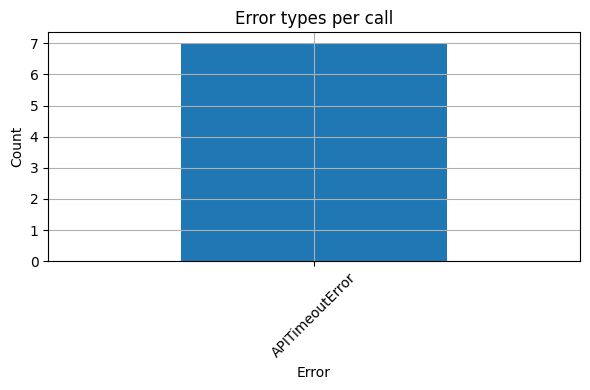

In [9]:

def plot_errors():
    error_counts = df['error'].dropna().value_counts()
    if not error_counts.empty:
        plt.figure(figsize=(6, 4))
        error_counts.plot(kind="bar")
        plt.title("Error types per call")
        plt.xlabel("Error")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("No errors recorded in this run.")
plot_errors()